In [ ]:
#Editted by Ralph Bulanadi
#Cleans domain walls
#Converts arrays into files that can be read by centerline_width to give info on domain wall thickness/sinuosity

In [1]:
#from ralph_tools import *
import re
import os
from matplotlib_scalebar.scalebar import ScaleBar
import time
import numpy as np
from glob import glob
#from igor2 import binarywave
import matplotlib.pyplot as plt
import h5py

from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from matplotlib.colors import hsv_to_rgb

In [2]:
import centerline_width

In [3]:
def jet_with_zero_transparent(n_colors=256):
    """
    Create a 'jet' colormap where only the lowest value (0) is fully transparent,
    and all other values are fully opaque.
    """
    base = plt.get_cmap('jet', n_colors)
    colors = base(np.arange(n_colors))
    
    # Make first color (lowest value) transparent, rest fully opaque
    colors[:, -1] = 1.0
    colors[:20, -1] = 0.0
    
    return ListedColormap(colors)


def unitize(ux, uy, uz, eps=1e-12):
    ux = np.asanyarray(ux, dtype=float)
    uy = np.asanyarray(uy, dtype=float)
    uz = np.asanyarray(uz, dtype=float)
    U = np.stack((ux, uy, uz), axis=-1)  # (H,W,3)
    mag = np.linalg.norm(U, axis=-1)
    valid = mag > eps
    mag_safe = mag.copy()
    mag_safe[~valid] = 1.0
    U_dir = U / mag_safe[..., None]
    U_dir[~valid] = 0.0
    return U_dir, valid

def angle_between_unit(a, b):
    # a,b shape (...,3)
    dot = np.sum(a * b, axis=-1)
    dot = np.clip(dot, -1.0, 1.0)
    return np.arccos(dot)

def most_common_opposite_angle_map_discrete(
        ux, uy, uz,
        radius=3,
        bin_width=np.pi/36,   # default: 5 degree bins
        min_pairs_required=4,
        eps=1e-12
    ):
    """
    For each pixel compute the most common angle (radians) between opposite discrete pixel pairs
    within integer offsets in a radius.

    Parameters
    ----------
    ux, uy, uz : 2D arrays (complex or real)
        Vector field components.
    radius : int
        Max integer radius to consider. Offsets considered are all integer (dy,dx) with
        dy^2 + dx^2 <= radius^2 and not (0,0).
    bin_width : float
        Histogram bin width in radians (must evenly divide pi for convenience but not required).
    min_pairs_required : int
        Minimum valid opposite pairs required to return a mode; otherwise result is np.nan.
    eps : float
        Small value to avoid division by zero when normalizing.

    Returns
    -------
    mode_map : float array (H,W)
        Per-pixel most common angle (radians) — center of modal bin; np.nan where insufficient pairs.
    modal_count_map : int array (H,W)
        Count of samples inside the modal bin for each pixel.
    total_pairs_map : int array (H,W)
        Total number of valid opposite pairs used for each pixel.
    bin_centers : 1D array
        The centers of histogram bins used (useful for interpretation).
    """
    # 1) Use real parts
    ux_r = np.real(ux)
    uy_r = np.real(uy)
    uz_r = np.real(uz)

    H, W = ux_r.shape

    # 2) Precompute unit vectors and valid mask
    U_dir, valid_vec_mask = unitize(ux_r, uy_r, uz_r, eps=eps)  # shape (H,W,3)

    # 3) Prepare integer offset list (dy,dx) within radius (exclude 0,0).
    offsets = []
    r2 = radius * radius
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            if dy == 0 and dx == 0:
                continue
            if dy*dy + dx*dx <= r2:
                # ensure we only keep one of the opposite pairs set later; we'll use both p+(dy,dx) & p-(dy,dx)
                # Keep every offset; opposite is just negative offset.
                offsets.append((dy, dx))
    # offsets contains duplicates of opposites; that's fine because each offset will generate one opposite pair.

    # 4) Histogram bin edges and centers (0..pi)
    # Ensure last edge >= pi
    n_bins = int(np.ceil(np.pi / bin_width))
    bin_edges = np.linspace(0.0, n_bins * bin_width, n_bins + 1)
    # if bin_edges[-1] < pi: extend one more bin to include pi
    if bin_edges[-1] < np.pi:
        bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
        n_bins = len(bin_edges) - 1
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Prepare outputs
    mode_map = np.full((H, W), np.nan, dtype=float)
    modal_count_map = np.zeros((H, W), dtype=int)
    total_pairs_map = np.zeros((H, W), dtype=int)

    # 5) Iterate over pixels (can be slow for very large images)
    for iy in range(H):
        for ix in range(W):
            angles_collected = []

            # For each integer offset, check both endpoints are in-bounds and valid vectors
            for (dy, dx) in offsets:
                y_plus = iy + dy
                x_plus = ix + dx
                y_minus = iy - dy
                x_minus = ix - dx

                # check bounds
                if (y_plus < 0 or y_plus >= H or x_plus < 0 or x_plus >= W or
                    y_minus < 0 or y_minus >= H or x_minus < 0 or x_minus >= W):
                    continue

                # check vector validity at both points
                if (not valid_vec_mask[y_plus, x_plus]) or (not valid_vec_mask[y_minus, x_minus]):
                    continue

                v_plus = U_dir[y_plus, x_plus, :]
                v_minus = U_dir[y_minus, x_minus, :]

                # compute angle
                ang = angle_between_unit(v_plus[None, :], v_minus[None, :])[0]
                # store
                angles_collected.append(ang)

            # end offsets loop

            total_pairs = len(angles_collected)
            total_pairs_map[iy, ix] = total_pairs

            if total_pairs >= min_pairs_required:
                counts, _ = np.histogram(angles_collected, bins=bin_edges)
                max_idx = np.argmax(counts)
                modal_count = counts[max_idx]
                modal_angle = bin_centers[max_idx]
                mode_map[iy, ix] = modal_angle
                modal_count_map[iy, ix] = int(modal_count)
            else:
                mode_map[iy, ix] = np.nan
                modal_count_map[iy, ix] = 0

    return mode_map, modal_count_map, total_pairs_map, bin_centers


In [4]:
file_loc = r'/Users/r9j/Code/Auto-3DPFM_v1-1/For_Hackathon/LASER_Images'

os.chdir(file_loc)
log_filename = 'Log_3DPFM'

In [ ]:
import cv2

for base_filename in glob('*hf5'):
    with (h5py.File(base_filename, 'r')) as f:
        ux = f['3DPFM/ux'][:]
        uy = f['3DPFM/uy'][:]
        uz = f['3DPFM/uz'][:]
        
        priority = ['B', 'C', 'A', 'E']
        Cnt = next((x for x in priority if x in f.keys()), None)
        
        topo = f[Cnt+'/Channel_000/Channel_000/Channel_000'][:]
        scale = f[Cnt+'/Channel_000/Channel_000/original_metadata'].attrs['FastScanSize']/f[Cnt+'/Channel_000/Channel_000/original_metadata'].attrs['PointsLines']
    
    U_mag = np.sqrt(np.abs(ux)**2+np.abs(uy)**2+np.abs(uz)**2)
    U_mag_max = min(U_mag.max(), 3e-9)


    mode_map, modal_count, total_pairs, bin_centers = most_common_opposite_angle_map_discrete(
        ux, uy, uz,
        radius=7,
        bin_width=np.pi/20,
        min_pairs_required=6
    )

    
    U_mag = np.sqrt(np.abs(ux)**2+np.abs(uy)**2+np.abs(uz)**2)
    background_img = np.real(uz).copy()
    
    angle_deg = mode_map * 180 / np.pi
    
    jet_zero_transparent = jet_with_zero_transparent()
    
    plt.imshow(background_img, cmap='binary_r', interpolation='none')
    
    plt.imshow(angle_deg, vmin=0, vmax=180,
               cmap=jet_zero_transparent, interpolation='none')
    
    plt.xticks([])
    plt.yticks([])
    #plt.colorbar(label="Angle (°)")
    plt.show()

    
    angle_deg = mode_map * 180 / np.pi


    from scipy import ndimage
    
    type1 = np.logical_and(mode_map >= np.radians(20), mode_map < np.radians(70))
    type2 = np.logical_and(mode_map < np.radians(130), mode_map >= np.radians(70))
    type12 = np.logical_and(mode_map < np.radians(130), mode_map >= np.radians(20))
    type3 = mode_map >= np.radians(130)
    type123 = mode_map >= np.radians(20)
    
    im = type1.astype('uint8')
    _, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(im)
    min_size = 100
    sizes = stats[:, cv2.CC_STAT_AREA]
    
    type1_clean = np.where(sizes[im_with_separated_blobs] >= min_size, im, 0)
    
    im = type2.astype('uint8')
    _, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(im)
    min_size = 100
    sizes = stats[:, cv2.CC_STAT_AREA]
    
    type2_clean = np.where(sizes[im_with_separated_blobs] >= min_size, im, 0)
    
    im = type3.astype('uint8')
    _, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(im)
    min_size = 100
    sizes = stats[:, cv2.CC_STAT_AREA]
    
    type3_clean = np.where(sizes[im_with_separated_blobs] >= min_size, im, 0)
    
    im = type12.astype('uint8')
    _, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(im)
    min_size = 100
    sizes = stats[:, cv2.CC_STAT_AREA]
    
    type12_clean = np.where(sizes[im_with_separated_blobs] >= min_size, im, 0)
    
    im = type123.astype('uint8')
    _, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(im)
    min_size = 100
    sizes = stats[:, cv2.CC_STAT_AREA]
    
    type123_clean = np.where(sizes[im_with_separated_blobs] >= min_size, im, 0)

    np.save(base_filename.split('.')[0]+"_U_mag.npy", U_mag)
    np.save(base_filename.split('.')[0]+"_type3.npy", type3_clean)
    np.save(base_filename.split('.')[0]+"_type2.npy", type2_clean)
    np.save(base_filename.split('.')[0]+"_type1.npy", type1_clean)
    np.save(base_filename.split('.')[0]+"_type12.npy", type12_clean)
    np.save(base_filename.split('.')[0]+"_type123.npy", type123_clean)

In [18]:
from scipy import ndimage

type1 = np.logical_and(mode_map >= np.radians(20), mode_map < np.radians(70))
type2 = np.logical_and(mode_map < np.radians(130), mode_map >= np.radians(70))
type3 = mode_map >= np.radians(130)

im = type1.astype('uint8')
im = ndimage.binary_erosion(im).astype(im.dtype)
_, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(im)
min_size = 100
sizes = stats[:, cv2.CC_STAT_AREA]

type1_clean = np.where(sizes[im_with_separated_blobs] >= min_size, im, 0)

im = type2.astype('uint8')
im = ndimage.binary_erosion(im).astype(im.dtype)
_, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(im)
min_size = 100
sizes = stats[:, cv2.CC_STAT_AREA]

type2_clean = np.where(sizes[im_with_separated_blobs] >= min_size, im, 0)

im = type3.astype('uint8')
_, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(im)
min_size = 100
sizes = stats[:, cv2.CC_STAT_AREA]

type3_clean = np.where(sizes[im_with_separated_blobs] >= min_size, im, 0)

In [7]:
import numpy as np

def find_c_tips_uturn(contour, w=30, top_k=2, suppress=40):
    """
    contour: (N,1,2) or (N,2) closed contour
    w: "handful of pixels" scale (try 2..6 for your contour)
    Returns indices of strongest U-turns.
    """
    pts = contour.reshape(-1, 2).astype(np.float32)
    n = len(pts)

    # step directions between consecutive points (directed by contour order)
    steps = np.roll(pts, -1, axis=0) - pts
    step_norm = np.linalg.norm(steps, axis=1, keepdims=True) + 1e-9
    steps_u = steps / step_norm

    # moving average of step directions (circular)
    def movavg(U, radius):
        acc = np.zeros_like(U)
        for k in range(radius):
            acc += np.roll(U, -k, axis=0)
        acc /= float(radius)
        acc /= (np.linalg.norm(acc, axis=1, keepdims=True) + 1e-9)
        return acc

    fwd = movavg(steps_u, w)                 # direction leaving i
    bwd = np.roll(movavg(steps_u, w), w, 0)  # direction arriving at i (aligned)

    # U-turn score: high when fwd and bwd are opposite
    dot = np.einsum("ij,ij->i", fwd, bwd)    # [-1,1]
    score = 1.0 - dot                        # [0,2], max at dot=-1

    # pick top_k peaks with circular non-max suppression
    order = np.argsort(score)[::-1]

    def circ_dist(a, b):
        d = abs(int(a) - int(b))
        return min(d, n - d)

    chosen = []
    for i in order:
        i = int(i)
        if any(circ_dist(i, c) <= suppress for c in chosen):
            continue
        chosen.append(i)
        if len(chosen) == top_k:
            break

    return chosen, score


In [59]:
U_mag = np.load("Image_U_mag.npy")
type1 = np.load("Image_type2.npy")


im = type1.astype('uint8')
_, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(im)
min_size = 100
sizes = stats[:, cv2.CC_STAT_AREA]

type1_clean = np.where(sizes[im_with_separated_blobs] >= min_size, im, 0)

In [ ]:
base_filename = 'Image.hf5'
with (h5py.File(base_filename, 'r')) as f:
    ux = f['3DPFM/ux'][:]
    uy = f['3DPFM/uy'][:]
    uz = f['3DPFM/uz'][:]
    
    priority = ['B', 'C', 'A', 'E']
    Cnt = next((x for x in priority if x in f.keys()), None)
    
    topo = f[Cnt+'/Channel_000/Channel_000/Channel_000'][:]
    scale = f[Cnt+'/Channel_000/Channel_000/original_metadata'].attrs['FastScanSize']/f[Cnt+'/Channel_000/Channel_000/original_metadata'].attrs['PointsLines']



mode_map, modal_count, total_pairs, bin_centers = most_common_opposite_angle_map_discrete(
    ux, uy, uz,
    radius=7,
    bin_width=np.pi/20,
    min_pairs_required=6
)


In [60]:

contours, hierarchy = cv2.findContours(type1_clean.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)



for i in range(len(contours)):
    cnt = contours[i]
    img = np.zeros_like(type1_clean.astype('uint8'))
    init_img = img.copy()
    #for i in range(115, 118):
    #cnt = contours[i]
    init_img = cv2.drawContours(init_img, [cnt], 0, 255, thickness=cv2.FILLED)
    #plt.imshow(init_img)
    #plt.show()
    #plt.close()

In [61]:
import csv
'''
chain_start_i = np.argmax(cnt[:,0,:], axis = 0)[1]
chain_end_i = np.argmin(cnt[:,0,:], axis = 0)[1]
contour_length = np.shape(cnt[:,0,:])[0]
'''

sinuosity_list = []

for i in range(len(contours)):
    try:
        cnt = contours[i]
        
        contour_length = np.shape(cnt[:,0,:])[0]
        w = int(contour_length / 5)
        suppress = 2*w
        
        chain_start_i = find_c_tips_uturn(cnt, w=w, suppress=suppress)[0][1]
        chain_end_i = find_c_tips_uturn(cnt, w=w, suppress=suppress)[0][0]
        
        if chain_end_i > chain_start_i:
            chain_end_i, chain_start_i = chain_start_i, chain_end_i
    
        chain_1_length = abs(chain_end_i - chain_start_i)
        chain_2_length = abs(chain_start_i - chain_end_i - contour_length)
    
    
        test_img = np.zeros_like(mode_map)
        
        chain_1 = []
        for i in range(chain_1_length):
            curr_i = chain_start_i + i
            if curr_i >=contour_length:
                curr_i -= contour_length
            #print(curr_i)
            test_img[cnt[curr_i][0][1], cnt[curr_i][0][0]] = 128
            chain_1.append([cnt[curr_i][0][1], cnt[curr_i][0][0]])
        
        chain_2 = []
        for i in range(chain_2_length):
            curr_i = chain_start_i - i
            if curr_i >=contour_length:
                curr_i -= contour_length   
            #print(curr_i)
            test_img[cnt[curr_i][0][1], cnt[curr_i][0][0]] = 255
            chain_2.append([cnt[curr_i][0][1], cnt[curr_i][0][0]])
    
        for i in range(len(chain_1)):
            chain_1[i][0] /= 100
            chain_1[i][1] /= 100
        
        for i in range(len(chain_2)):
            chain_2[i][0] /= 100
            chain_2[i][1] /= 100
    
        header = ['llat','llon','rlat','rlon']
        
        with open('some.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)
            for i in range(max([len(chain_1), len(chain_2)])):
                row = []
                if i >= len(chain_1):
                    row.extend(chain_1[-1])
                else:
                    row.extend(chain_1[i])
                
                if i >= len(chain_2):
                    row.extend(chain_2[-1])
                else:
                    row.extend(chain_2[i])
                writer.writerow(row)
    
        river_object = centerline_width.CenterlineWidth(csv_data='some.csv',)
        sinuosity_list.append(river_object.sinuosity)
    except:
        continue

[FAILED]  Invalid Polygon may need to be corrected - Decimal Degrees
[FAILED]  Invalid Polygon may need to be corrected - Relative Distance
[SUCCESS] Voronoi diagram generated - Decimal Degrees
[SUCCESS] Voronoi diagram generated - Relative Distance
[PROCESSING] Attempting to determine a valid centerline from Voronoi points, may take a few minutes...
[FAILED]  No direct path found from starting node to ending node. To view gaps, plot_centerline(display_all_possible_paths=True). Recommended fix, rerun CenterlineWidth: set interpolate_data=True or (if interpolate_data=True) increase interpolate_n
[FAILED]  Invalid Polygon may need to be corrected - Decimal Degrees
[FAILED]  Invalid Polygon may need to be corrected - Relative Distance
[SUCCESS] Voronoi diagram generated - Decimal Degrees
[SUCCESS] Voronoi diagram generated - Relative Distance
[PROCESSING] Attempting to determine a valid centerline from Voronoi points, may take a few minutes...
[SUCCESS] Valid centerline path found
[FAILED

(array([ 8.,  0.,  0., 71.,  0.,  0.,  0.,  2.,  0.,  1.]),
 array([0.        , 0.30782969, 0.61565938, 0.92348907, 1.23131876,
        1.53914845, 1.84697814, 2.15480783, 2.46263752, 2.7704672 ,
        3.07829689]),
 <BarContainer object of 10 artists>)

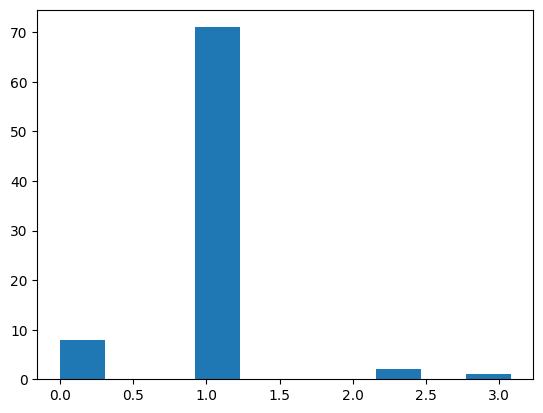

In [62]:
plt.hist(sinuosity_list)

In [25]:
sinuosity_list_3 = sinuosity_list.copy()

In [757]:
sinuosity_list_2 = sinuosity_list.copy()

In [63]:
sinuosity_list_1 = sinuosity_list.copy()

In [81]:
arr = np.array(sinuosity_list_1)
np.mean(arr[arr != 0])

np.float64(1.1249399161339186)

In [82]:
arr = np.array(sinuosity_list_1)
np.std(arr[arr != 0])

np.float64(0.3070643208474164)

In [83]:
arr = np.array(sinuosity_list_3)
np.mean(arr[arr != 0])

np.float64(1.235500220098458)

In [84]:
arr = np.array(sinuosity_list_3)
np.std(arr[arr != 0])

np.float64(0.4973100237029238)

In [77]:
sinuosity_list_3 != 0

True

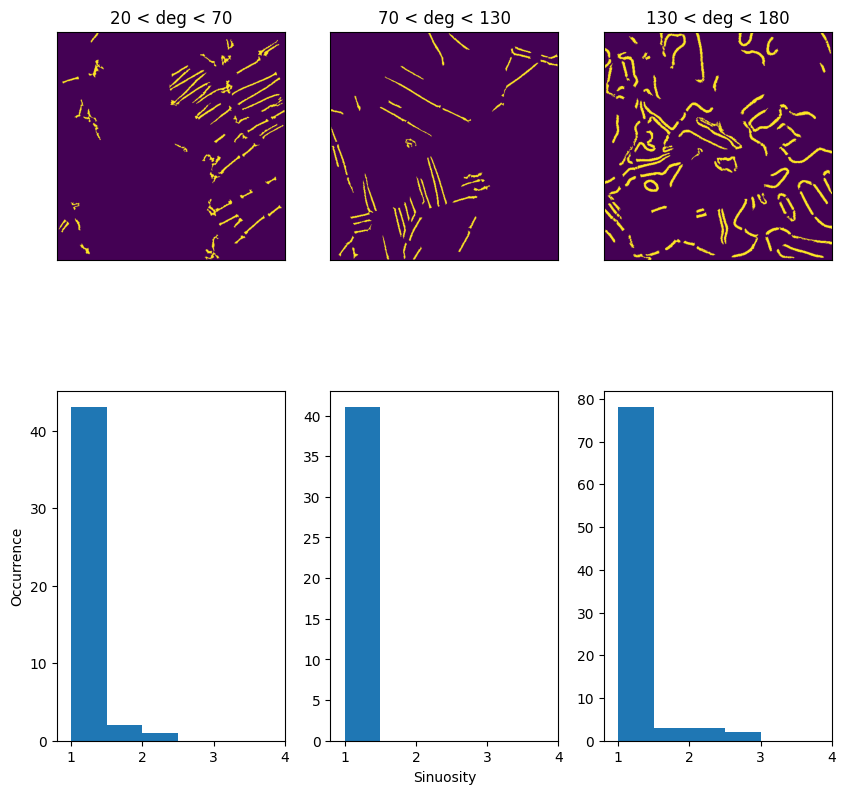

In [775]:
plt.figure(figsize = (10,10))
plt.subplot(2,3,1)
plt.title('20 < deg < 70')
plt.imshow(type1_clean)
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,2)
plt.title('70 < deg < 130')
plt.imshow(type2_clean)
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,3)
plt.title('130 < deg < 180')
plt.imshow(type3_clean)
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,4)
plt.hist(sinuosity_list_1, bins = [0.5, 1, 1.5, 2, 2.5, 3])
plt.ylabel('Occurrence')
plt.xlim(0.8, 4)
plt.subplot(2,3,5)
plt.hist(sinuosity_list_2, bins = [0.5, 1, 1.5, 2, 2.5, 3])
plt.xlim(0.8, 4)
plt.xlabel('Sinuosity')
plt.subplot(2,3,6)
plt.hist(sinuosity_list_3, bins = [0.5, 1, 1.5, 2, 2.5, 3])
plt.xlim(0.8, 4)
plt.savefig('Sinuosity_and_DW_Angle.png')

(array([ 6.,  0.,  0.,  0., 41.,  2.,  0.,  2.,  0.,  1.]),
 array([0.        , 0.2378131 , 0.47562621, 0.71343931, 0.95125241,
        1.18906552, 1.42687862, 1.66469172, 1.90250483, 2.14031793,
        2.37813103]),
 <BarContainer object of 10 artists>)

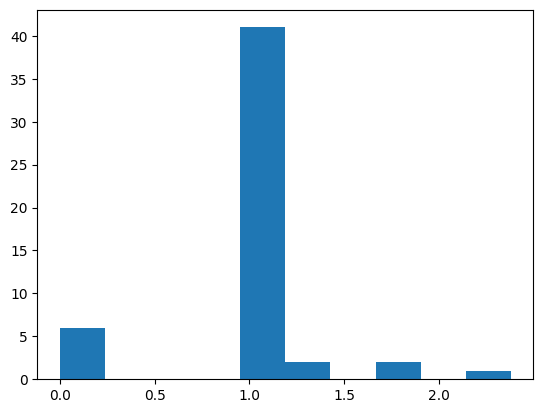

In [745]:
plt.hist(sinuosity_list_3)

(array([ 6.,  0.,  0.,  0., 41.,  2.,  0.,  2.,  0.,  1.]),
 array([0.        , 0.2378131 , 0.47562621, 0.71343931, 0.95125241,
        1.18906552, 1.42687862, 1.66469172, 1.90250483, 2.14031793,
        2.37813103]),
 <BarContainer object of 10 artists>)

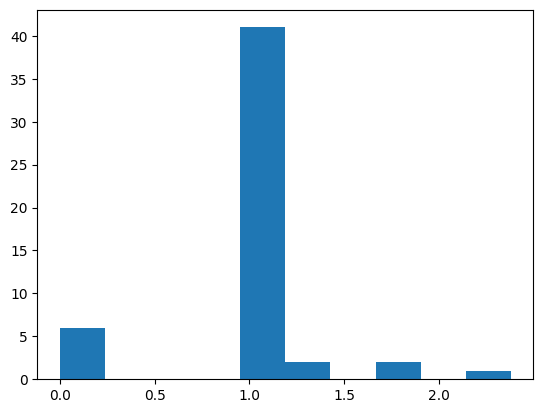

In [746]:
plt.hist(sinuosity_list_1)

In [643]:
contour_length

91

In [644]:
find_c_tips_uturn(cnt)[0]

[77, 27]

In [645]:
chain_end_i

19

In [647]:


test_img = np.zeros_like(mode_map)

chain_1 = []
for i in range(chain_1_length):
    curr_i = chain_start_i + i
    if curr_i >=contour_length:
        curr_i -= contour_length
    #print(curr_i)
    test_img[cnt[curr_i][0][1], cnt[curr_i][0][0]] = 128
    chain_1.append([cnt[curr_i][0][1], cnt[curr_i][0][0]])

chain_2 = []
for i in range(chain_2_length):
    curr_i = chain_start_i - i
    if curr_i >=contour_length:
        curr_i -= contour_length   
    #print(curr_i)
    test_img[cnt[curr_i][0][1], cnt[curr_i][0][0]] = 255
    chain_2.append([cnt[curr_i][0][1], cnt[curr_i][0][0]])

In [648]:
for i in range(len(chain_1)):
    chain_1[i][0] /= 100
    chain_1[i][1] /= 100

for i in range(len(chain_2)):
    chain_2[i][0] /= 100
    chain_2[i][1] /= 100

In [649]:
import csv

header = ['llat','llon','rlat','rlon']

with open('some.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(max([len(chain_1), len(chain_2)])):
        row = []
        if i >= len(chain_1):
            row.extend(chain_1[-1])
        else:
            row.extend(chain_1[i])
        
        if i >= len(chain_2):
            row.extend(chain_2[-1])
        else:
            row.extend(chain_2[i])
        writer.writerow(row)

In [650]:
river_object = centerline_width.CenterlineWidth(csv_data='some.csv',)
                #cutoff=None,
                #interpolate_data=False,
                #interpolate_n=5,
                #interpolate_n_centerpoints=None,
                #equal_distance=10,
                #ellipsoid="WGS84")

[FAILED]  Invalid Polygon may need to be corrected - Decimal Degrees
[FAILED]  Invalid Polygon may need to be corrected - Relative Distance
[SUCCESS] Voronoi diagram generated - Decimal Degrees
[SUCCESS] Voronoi diagram generated - Relative Distance
[PROCESSING] Attempting to determine a valid centerline from Voronoi points, may take a few minutes...
[SUCCESS] Valid centerline path found


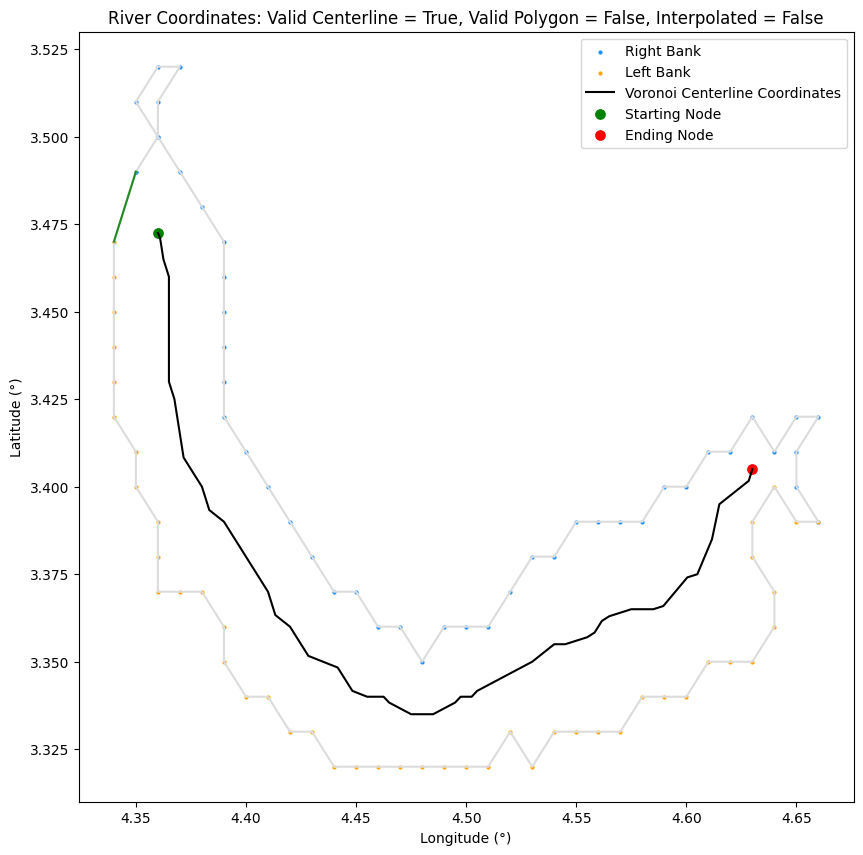

In [651]:
river_object.plot_centerline()

[PROCESSING] Calculating and positioning width lines, may take a few minutes...
[PROCESSING] Recursively removing intersection lines...
[SUCCESS] Intersection lines removed


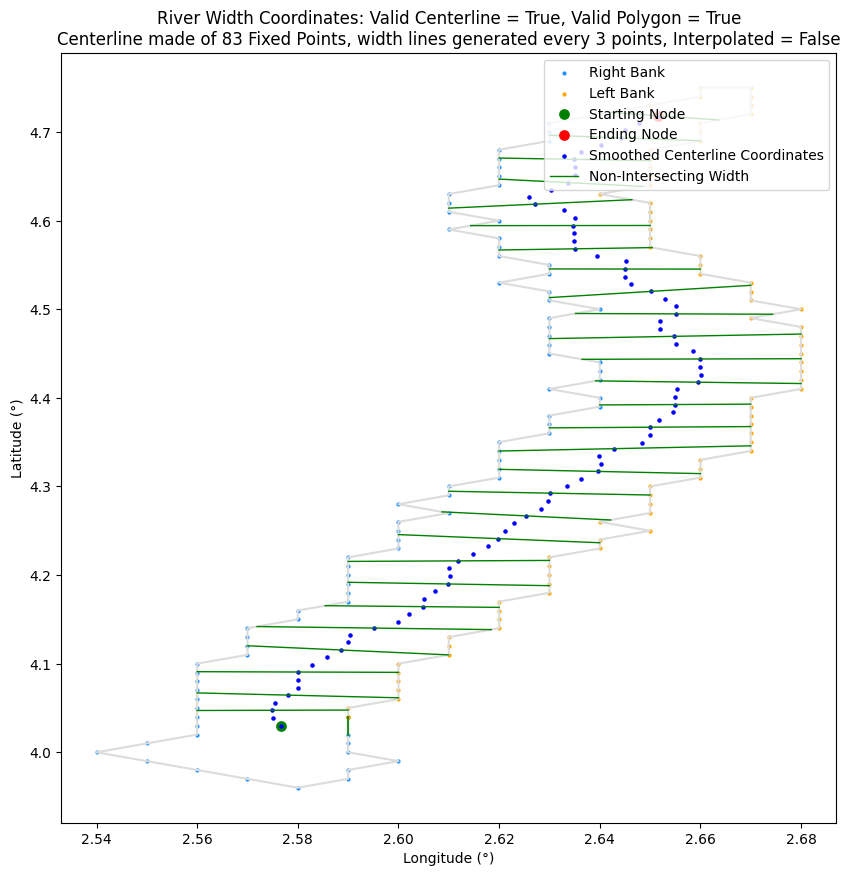

In [484]:
river_object.plot_centerline_width(apply_smoothing=True, remove_intersections=True, display_true_centerline=False)

In [485]:
river_object.sinuosity

1.0390050213387754

In [143]:
cnt

array([[[444, 332]],

       [[443, 333]],

       [[442, 333]],

       [[441, 334]],

       [[440, 334]],

       [[439, 335]],

       [[439, 336]],

       [[438, 337]],

       [[437, 337]],

       [[436, 337]],

       [[436, 338]],

       [[436, 339]],

       [[435, 340]],

       [[435, 341]],

       [[434, 342]],

       [[434, 343]],

       [[434, 344]],

       [[434, 345]],

       [[434, 346]],

       [[434, 347]],

       [[435, 348]],

       [[435, 349]],

       [[436, 350]],

       [[435, 351]],

       [[436, 352]],

       [[437, 352]],

       [[436, 351]],

       [[436, 350]],

       [[437, 349]],

       [[438, 348]],

       [[439, 347]],

       [[439, 346]],

       [[439, 345]],

       [[439, 344]],

       [[439, 343]],

       [[439, 342]],

       [[440, 341]],

       [[441, 340]],

       [[442, 339]],

       [[443, 338]],

       [[444, 337]],

       [[445, 337]],

       [[446, 336]],

       [[447, 336]],

       [[448, 335]],

       [[4

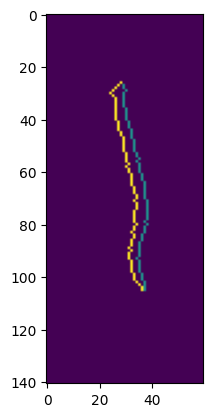

In [47]:
plt.imshow(test_img[370:,230:290])

In [269]:
cnt

array([[[258, 396]],

       [[257, 397]],

       [[256, 398]],

       [[255, 399]],

       [[254, 400]],

       [[255, 401]],

       [[256, 402]],

       [[256, 403]],

       [[256, 404]],

       [[256, 405]],

       [[256, 406]],

       [[256, 407]],

       [[256, 408]],

       [[256, 409]],

       [[256, 410]],

       [[257, 411]],

       [[257, 412]],

       [[257, 413]],

       [[257, 414]],

       [[258, 415]],

       [[258, 416]],

       [[259, 417]],

       [[259, 418]],

       [[259, 419]],

       [[259, 420]],

       [[259, 421]],

       [[259, 422]],

       [[260, 423]],

       [[260, 424]],

       [[260, 425]],

       [[260, 426]],

       [[261, 427]],

       [[260, 428]],

       [[261, 429]],

       [[261, 430]],

       [[262, 431]],

       [[262, 432]],

       [[262, 433]],

       [[262, 434]],

       [[262, 435]],

       [[263, 436]],

       [[263, 437]],

       [[263, 438]],

       [[264, 439]],

       [[264, 440]],

       [[2